# Validation Report: Standalone Classification

Objective:
- Validate `separation.classification` against pre-saved baseline artifacts captured from the original Suite2p pipeline.

Data sources:
- `separation/classification/test_input.pkl` (captured `classify(...)` kwargs)
- `separation/classification/test_output.pkl` (captured original-pipeline `iscell` output)
- `separation/classification/capture_manifest.json` (capture provenance)

Critical architecture rule:
- This notebook must not import the original parent library (`suite2p`) during standalone execution.
- Validation is performed by replaying standalone code against captured artifacts only.


In [1]:
from __future__ import annotations

import builtins
import importlib
import importlib.util
import json
import pickle
import re
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

if any(name == "suite2p" or name.startswith("suite2p.") for name in sys.modules):
    raise RuntimeError(
        "Architecture rule violation: `suite2p` is already loaded in this kernel. "
        "Restart the kernel and run this notebook from the top."
    )


class BlockSuite2PImports:
    # Block suite2p imports to prevent namespace pollution.
    def __enter__(self):
        self._orig_import = builtins.__import__

        def guarded_import(name, globals=None, locals=None, fromlist=(), level=0):
            if name == "suite2p" or name.startswith("suite2p."):
                raise ImportError(f"Blocked import by architecture rule: {name}")
            return self._orig_import(name, globals, locals, fromlist, level)

        builtins.__import__ = guarded_import
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        builtins.__import__ = self._orig_import


def find_repo_root(start: Path):
    current = start.resolve()
    for candidate in [current, *current.parents]:
        if (candidate / ".git").exists():
            return candidate
    return None


def load_module_from_file(module_name: str, file_path: Path):
    spec = importlib.util.spec_from_file_location(module_name, str(file_path))
    if spec is None or spec.loader is None:
        raise ImportError(f"Failed to create spec for {module_name} from {file_path}")
    module = importlib.util.module_from_spec(spec)
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module


def import_standalone_helpers(notebook_dir: Path, repo_root):
    try:
        from separation.classification.serialization import deserialize_object as _deserialize_object
        return _deserialize_object, "standard"
    except Exception:
        pass

    if repo_root is not None:
        repo_root_str = str(repo_root)
        if repo_root_str not in sys.path:
            sys.path.insert(0, repo_root_str)
        try:
            from separation.classification.serialization import deserialize_object as _deserialize_object
            return _deserialize_object, "repo_root_bootstrap"
        except Exception:
            pass

    package_dir = notebook_dir
    if not (package_dir / "serialization.py").exists():
        package_dir = notebook_dir / "separation" / "classification"
    if not (package_dir / "serialization.py").exists():
        raise ImportError(
            f"Could not locate standalone classification helper modules near {notebook_dir}."
        )

    serialization_mod = load_module_from_file(
        "standalone_classification_serialization_local", package_dir / "serialization.py"
    )
    return serialization_mod.deserialize_object, "local_loader"


def import_standalone_package(package_dir: Path, repo_root):
    try:
        module = importlib.import_module("separation.classification")
        return module, "separation.classification", "standard"
    except Exception:
        pass

    if repo_root is not None:
        repo_root_str = str(repo_root)
        if repo_root_str not in sys.path:
            sys.path.insert(0, repo_root_str)
        try:
            module = importlib.import_module("separation.classification")
            return module, "separation.classification", "repo_root_bootstrap"
        except Exception:
            pass

    init_file = package_dir / "__init__.py"
    if not init_file.exists():
        raise FileNotFoundError(f"Standalone package init not found: {init_file}")

    module_name = "standalone_classification_local"
    spec = importlib.util.spec_from_file_location(
        module_name,
        str(init_file),
        submodule_search_locations=[str(package_dir)],
    )
    if spec is None or spec.loader is None:
        raise ImportError(f"Failed to create package spec from {init_file}")
    module = importlib.util.module_from_spec(spec)
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module, module_name, "local_loader"


def normalize_builtin_classfile(kwargs, package_dir: Path):
    kwargs = dict(kwargs)
    classfile = kwargs.get("classfile")
    classfile_str = str(classfile) if classfile is not None else ""
    if classfile_str.endswith("/suite2p/classifiers/classifier.npy"):
        kwargs["classfile"] = package_dir / "classifiers" / "classifier.npy"
    return kwargs


def assert_island_rule_static(package_dir: Path):
    import_pattern = re.compile(r"^\s*(?:from|import)\s+suite2p\b")
    offenders = []
    for py_path in package_dir.rglob("*.py"):
        if "__pycache__" in py_path.parts:
            continue
        for lineno, line in enumerate(py_path.read_text().splitlines(), start=1):
            if import_pattern.search(line):
                offenders.append(f"{py_path}:{lineno}: {line.strip()}")

    if offenders:
        detail = "\n".join(offenders)
        raise AssertionError(f"Island rule violation: found suite2p imports\n{detail}")
    return True


notebook_dir = Path.cwd().resolve()
repo_root = find_repo_root(notebook_dir)
deserialize_object, import_strategy_used = import_standalone_helpers(
    notebook_dir=notebook_dir,
    repo_root=repo_root,
)

architecture_guard_initialized = True
print("Architecture guard initialized.")
print(f"Python {sys.version.split()[0]}")
print(f"notebook_dir={notebook_dir}")
print(f"repo_root={repo_root}")
print(f"helper_import_strategy={import_strategy_used}")


Architecture guard initialized.
Python 3.9.25
notebook_dir=/home/yz/suite2p/separation/classification
repo_root=/home/yz/suite2p
helper_import_strategy=repo_root_bootstrap


In [2]:
artifact_dir_candidates = []
if repo_root is not None:
    artifact_dir_candidates.append(repo_root / "separation" / "classification")
artifact_dir_candidates.extend(
    [
        Path("/mnt/nas02/Dataset/suite2p/classification"),
        Path("/home/yz/suite2p/separation/classification"),
    ]
)

artifact_dir = None
for candidate in artifact_dir_candidates:
    if (candidate / "test_input.pkl").exists() and (candidate / "test_output.pkl").exists():
        artifact_dir = candidate
        break

if artifact_dir is None:
    raise FileNotFoundError(
        "Could not find classification artifacts. Checked: "
        + ", ".join(str(p) for p in artifact_dir_candidates)
    )

package_dir = repo_root / "separation" / "classification" if repo_root is not None else Path("separation/classification")

test_input_path = artifact_dir / "test_input.pkl"
test_output_path = artifact_dir / "test_output.pkl"
manifest_path = artifact_dir / "capture_manifest.json"

missing = [
    str(p) for p in [test_input_path, test_output_path, manifest_path]
    if not p.exists()
]
if missing:
    raise FileNotFoundError("Missing required classification artifacts: " + ", ".join(missing))

print(f"artifact_dir:     {artifact_dir}")
print(f"package_dir:      {package_dir}")
print(f"test_input_path:  {test_input_path}")
print(f"test_output_path: {test_output_path}")
print(f"manifest_path:    {manifest_path}")


artifact_dir:     /home/yz/suite2p/separation/classification
package_dir:      /home/yz/suite2p/separation/classification
test_input_path:  /home/yz/suite2p/separation/classification/test_input.pkl
test_output_path: /home/yz/suite2p/separation/classification/test_output.pkl
manifest_path:    /home/yz/suite2p/separation/classification/capture_manifest.json


In [3]:
with test_input_path.open("rb") as f:
    captured_input_serialized = pickle.load(f)

print("Loaded captured_input_serialized")
print("top-level keys:", sorted(captured_input_serialized.keys()))
print("type summary:")
for key in sorted(captured_input_serialized.keys()):
    value = captured_input_serialized[key]
    if isinstance(value, dict) and "__type__" in value:
        print(f"  - {key}: serialized {value['__type__']}")
    else:
        print(f"  - {key}: {type(value).__name__}")


Loaded captured_input_serialized
top-level keys: ['classfile', 'keys', 'stat']
type summary:
  - classfile: serialized path
  - keys: serialized tuple
  - stat: serialized ndarray_object


In [4]:
with test_output_path.open("rb") as f:
    expected_output_serialized = pickle.load(f)

manifest = json.loads(manifest_path.read_text())

print("Loaded expected_output_serialized")
print("expected_output_serialized type:", type(expected_output_serialized).__name__)
if isinstance(expected_output_serialized, dict):
    print("serialized output keys:", sorted(expected_output_serialized.keys()))

print("\nCapture manifest summary:")
print("  captured_at_utc:", manifest.get("captured_at_utc"))
print("  run_dir:", manifest.get("run_dir"))
print("  device:", manifest.get("device"))
print("  settings_run:", manifest.get("settings_run"))
print("  classification_settings:", manifest.get("classification_settings"))


Loaded expected_output_serialized
expected_output_serialized type: dict
serialized output keys: ['__type__', 'data', 'dtype', 'shape']

Capture manifest summary:
  captured_at_utc: 2026-02-28T14:23:55.036823+00:00
  run_dir: /mnt/nas02/Dataset/suite2p/output/classification_capture/run_20260228T142325Z
  device: cpu
  settings_run: {'do_registration': 1, 'do_regmetrics': False, 'do_detection': True, 'do_deconvolution': False, 'multiplane_parallel': False}
  classification_settings: {'classifier_path': None, 'use_builtin_classifier': False, 'preclassify': 0.0}


In [5]:
kwargs = deserialize_object(captured_input_serialized)
expected_output = deserialize_object(expected_output_serialized)

if not isinstance(kwargs, dict):
    raise TypeError(f"Expected kwargs to be dict, got {type(kwargs).__name__}")

kwargs = normalize_builtin_classfile(kwargs, package_dir=package_dir)

if "stat" not in kwargs:
    raise KeyError("Expected `stat` in captured kwargs")
if len(kwargs["stat"]) == 0:
    raise ValueError("Captured stat is empty; cannot validate classification")

print("Deserialized kwargs keys:", sorted(kwargs.keys()))
print("Deserialized expected_output type:", type(expected_output).__name__)
print("classfile:", kwargs.get("classfile"))
print("keys:", kwargs.get("keys"))
print("n_stat:", len(kwargs.get("stat", [])))

example_keys = sorted(list(kwargs["stat"][0].keys()))
print("first ROI stat keys (sample):", example_keys[:20], "... total", len(example_keys))


Deserialized kwargs keys: ['classfile', 'keys', 'stat']
Deserialized expected_output type: ndarray
classfile: /home/yz/suite2p/separation/classification/classifiers/classifier.npy
keys: ('skew', 'npix_norm', 'compact')
n_stat: 77
first ROI stat keys (sample): ['aspect_ratio', 'compact', 'footprint', 'lam', 'med', 'mrs', 'mrs0', 'npix', 'npix_norm', 'npix_norm_no_crop', 'npix_soma', 'overlap', 'radius', 'skew', 'snr', 'soma_crop', 'std', 'xpix', 'ypix'] ... total 19


In [6]:
island_rule_static_ok = assert_island_rule_static(package_dir)
print("Island-rule static scan passed:", island_rule_static_ok)


Island-rule static scan passed: True


In [7]:
new_output = None
new_output_second = None
architecture_guard_status = False
standalone_package_name = None
package_import_strategy = None

with BlockSuite2PImports():
    standalone_module, standalone_package_name, package_import_strategy = import_standalone_package(
        package_dir=package_dir,
        repo_root=repo_root,
    )
    architecture_guard_status = True
    new_output = standalone_module.classify(**kwargs)
    # Determinism check: repeated run with identical input.
    new_output_second = standalone_module.classify(**kwargs)

print("Standalone execution completed.")
print(f"standalone_package_name={standalone_package_name}")
print(f"package_import_strategy={package_import_strategy}")
print("new_output shape:", getattr(new_output, "shape", None))


Standalone execution completed.
standalone_package_name=separation.classification
package_import_strategy=standard
new_output shape: (77, 2)


In [8]:
comparison_rows = []

def add_row(path, kind, expected, actual, passed, detail, max_abs_error=None):
    shape_expected = tuple(expected.shape) if isinstance(expected, np.ndarray) else None
    shape_actual = tuple(actual.shape) if isinstance(actual, np.ndarray) else None
    comparison_rows.append(
        {
            "path": path,
            "kind": kind,
            "shape_expected": shape_expected,
            "shape_actual": shape_actual,
            "pass": bool(passed),
            "max_abs_error": max_abs_error,
            "detail": detail,
        }
    )


def compare_objects(expected, actual, path="root"):
    if isinstance(expected, dict):
        if not isinstance(actual, dict):
            add_row(path, "dict", expected, actual, False, f"type mismatch: expected dict, got {type(actual).__name__}")
            return

        expected_keys = set(expected.keys())
        actual_keys = set(actual.keys())
        if expected_keys != actual_keys:
            missing = sorted(expected_keys - actual_keys)
            extra = sorted(actual_keys - expected_keys)
            add_row(
                path,
                "dict_keys",
                expected,
                actual,
                False,
                f"key mismatch; missing={missing}, extra={extra}",
            )

        for key in sorted(expected_keys & actual_keys):
            compare_objects(expected[key], actual[key], path=f"{path}.{key}")
        return

    if isinstance(expected, tuple):
        if not isinstance(actual, tuple):
            add_row(path, "tuple", expected, actual, False, f"type mismatch: expected tuple, got {type(actual).__name__}")
            return
        if len(expected) != len(actual):
            add_row(path, "tuple_len", expected, actual, False, f"length mismatch: {len(expected)} != {len(actual)}")
        for idx, (exp_item, act_item) in enumerate(zip(expected, actual)):
            compare_objects(exp_item, act_item, path=f"{path}[{idx}]")
        return

    if isinstance(expected, list):
        if not isinstance(actual, list):
            add_row(path, "list", expected, actual, False, f"type mismatch: expected list, got {type(actual).__name__}")
            return
        if len(expected) != len(actual):
            add_row(path, "list_len", expected, actual, False, f"length mismatch: {len(expected)} != {len(actual)}")
        for idx, (exp_item, act_item) in enumerate(zip(expected, actual)):
            compare_objects(exp_item, act_item, path=f"{path}[{idx}]")
        return

    if isinstance(expected, np.ndarray):
        if not isinstance(actual, np.ndarray):
            add_row(path, "ndarray", expected, actual, False, f"type mismatch: expected ndarray, got {type(actual).__name__}")
            return

        if expected.dtype != actual.dtype:
            add_row(path, "ndarray_dtype", expected, actual, False, f"dtype mismatch: {expected.dtype} != {actual.dtype}")
            return

        if expected.shape != actual.shape:
            add_row(path, "ndarray_shape", expected, actual, False, f"shape mismatch: {expected.shape} != {actual.shape}")
            return

        if expected.dtype == object:
            for idx in np.ndindex(expected.shape):
                compare_objects(expected[idx], actual[idx], path=f"{path}[{idx}]")
            return

        if np.issubdtype(expected.dtype, np.floating):
            diff = np.abs(expected.astype(np.float64) - actual.astype(np.float64))
            max_abs_error = float(np.nanmax(diff)) if diff.size else 0.0
            try:
                np.testing.assert_allclose(expected, actual, rtol=0.0, atol=0.0, equal_nan=True)
                add_row(path, "ndarray_float", expected, actual, True, "exact float match", max_abs_error=max_abs_error)
            except AssertionError as exc:
                add_row(path, "ndarray_float", expected, actual, False, str(exc).splitlines()[0], max_abs_error=max_abs_error)
        else:
            passed = bool(np.array_equal(expected, actual))
            add_row(
                path,
                "ndarray_exact",
                expected,
                actual,
                passed,
                "exact array match" if passed else "array values differ",
                max_abs_error=None,
            )
        return

    if type(expected) is not type(actual):
        add_row(path, "scalar_type", expected, actual, False, f"type mismatch: {type(expected).__name__} != {type(actual).__name__}")
        return

    passed = expected == actual
    add_row(path, "scalar", expected, actual, passed, "exact scalar match" if passed else f"value mismatch: {expected!r} != {actual!r}")


compare_objects(expected_output, new_output, path="root")
compare_objects(new_output, new_output_second, path="repeat")

failed_rows = [row for row in comparison_rows if not row["pass"]]
overall_pass = len(failed_rows) == 0

print(f"Total checks: {len(comparison_rows)}")
print(f"Passed: {len(comparison_rows) - len(failed_rows)}")
print(f"Failed: {len(failed_rows)}")
print(f"Overall PASS: {overall_pass}")

if failed_rows:
    print("\nFailed rows:")
    for row in failed_rows[:20]:
        print(
            f"  - {row['path']} | kind={row['kind']} | "
            f"max_abs_error={row['max_abs_error']} | detail={row['detail']}"
        )


Total checks: 2
Passed: 2
Failed: 0
Overall PASS: True


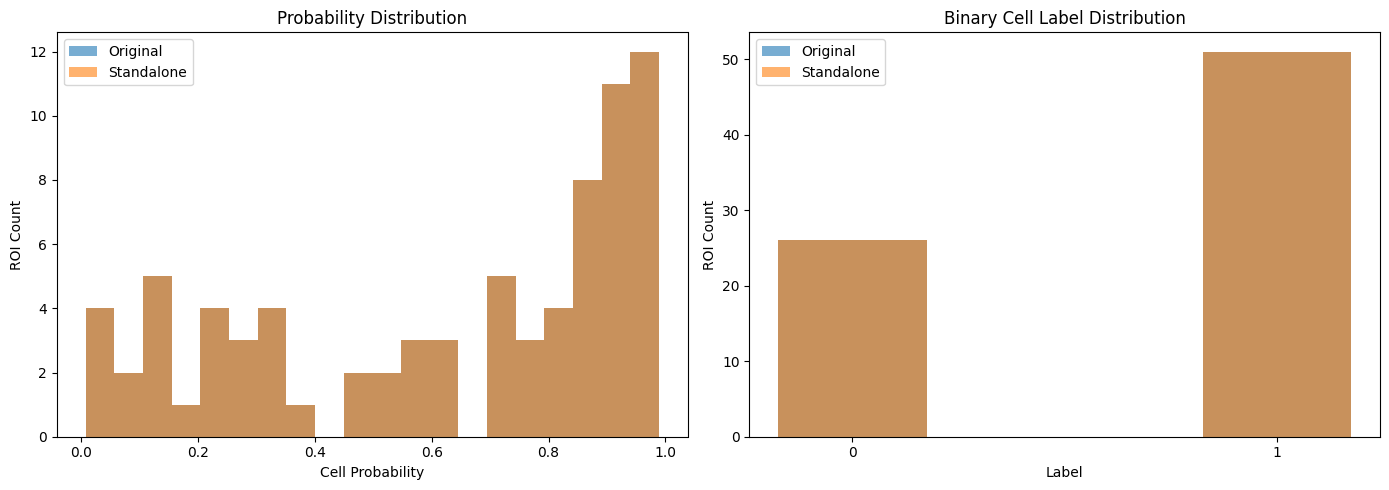

In [9]:
expected_iscell = np.asarray(expected_output)
new_iscell = np.asarray(new_output)

df_expected = expected_iscell[:, 0].astype(np.float64)
df_new = new_iscell[:, 0].astype(np.float64)
prob_expected = expected_iscell[:, 1].astype(np.float64)
prob_new = new_iscell[:, 1].astype(np.float64)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(prob_expected, bins=20, alpha=0.6, label="Original", color="tab:blue")
axes[0].hist(prob_new, bins=20, alpha=0.6, label="Standalone", color="tab:orange")
axes[0].set_title("Probability Distribution")
axes[0].set_xlabel("Cell Probability")
axes[0].set_ylabel("ROI Count")
axes[0].legend()

axes[1].hist(df_expected, bins=np.array([-0.5, 0.5, 1.5]), alpha=0.6, label="Original", rwidth=0.35, color="tab:blue")
axes[1].hist(df_new, bins=np.array([-0.5, 0.5, 1.5]), alpha=0.6, label="Standalone", rwidth=0.35, color="tab:orange")
axes[1].set_xticks([0, 1])
axes[1].set_title("Binary Cell Label Distribution")
axes[1].set_xlabel("Label")
axes[1].set_ylabel("ROI Count")
axes[1].legend()

plt.tight_layout()
plt.show()


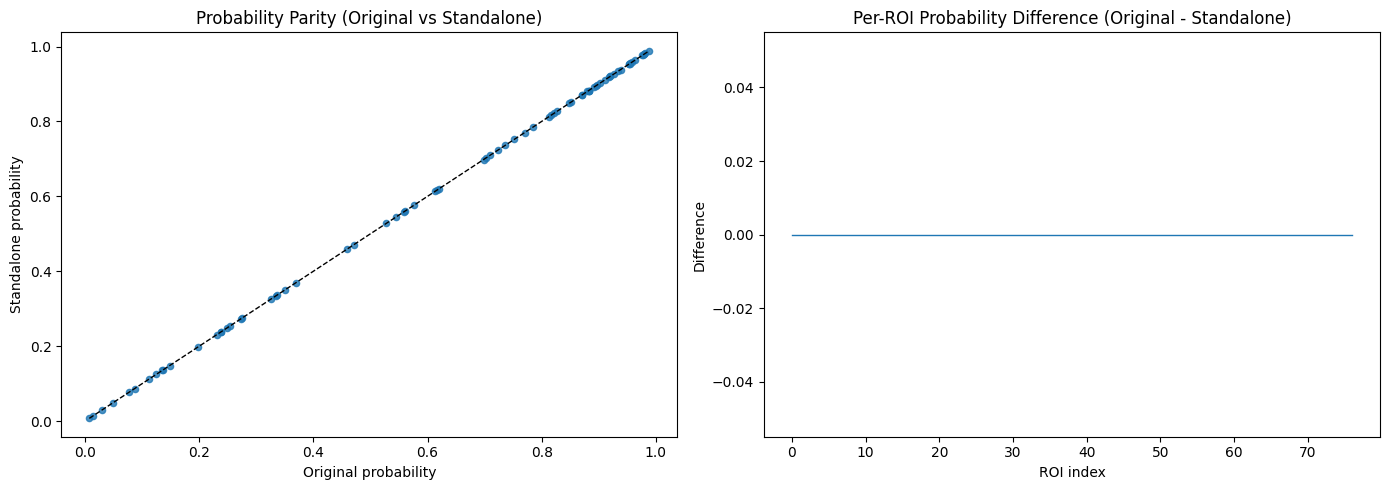

max_abs_prob_diff=0.0
mean_abs_prob_diff=0.0


In [10]:
expected_prob = expected_output[:, 1].astype(np.float64)
new_prob = new_output[:, 1].astype(np.float64)
prob_diff = expected_prob - new_prob

max_abs_prob_diff = float(np.max(np.abs(prob_diff))) if prob_diff.size else 0.0
mean_abs_prob_diff = float(np.mean(np.abs(prob_diff))) if prob_diff.size else 0.0

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(expected_prob, new_prob, s=20, alpha=0.8)
mn = float(min(expected_prob.min(), new_prob.min())) if expected_prob.size else 0.0
mx = float(max(expected_prob.max(), new_prob.max())) if expected_prob.size else 1.0
axes[0].plot([mn, mx], [mn, mx], "k--", linewidth=1)
axes[0].set_title("Probability Parity (Original vs Standalone)")
axes[0].set_xlabel("Original probability")
axes[0].set_ylabel("Standalone probability")

axes[1].plot(prob_diff, linewidth=1)
axes[1].set_title("Per-ROI Probability Difference (Original - Standalone)")
axes[1].set_xlabel("ROI index")
axes[1].set_ylabel("Difference")

plt.tight_layout()
plt.show()

print(f"max_abs_prob_diff={max_abs_prob_diff}")
print(f"mean_abs_prob_diff={mean_abs_prob_diff}")


In [11]:
expected_label = expected_output[:, 0].astype(np.int64)
new_label = new_output[:, 0].astype(np.int64)

label_mismatch = np.flatnonzero(expected_label != new_label)
prob_diff = np.abs(expected_output[:, 1].astype(np.float64) - new_output[:, 1].astype(np.float64))

print("Label agreement diagnostics")
print("==========================")
print(f"n_rois={len(expected_label)}")
print(f"label_mismatch_count={len(label_mismatch)}")
print(f"prob_diff_nonzero_count={(prob_diff > 0).sum()}")

if len(label_mismatch):
    print("First mismatch indices:", label_mismatch[:20].tolist())

# Top-N ROI by probability absolute error
n_top = min(10, len(prob_diff))
top_idx = np.argsort(-prob_diff)[:n_top]
print("\nTop ROI absolute probability errors:")
for rank, idx in enumerate(top_idx, start=1):
    print(
        f"  {rank:02d} idx={int(idx):4d} "
        f"expected_label={int(expected_label[idx])} new_label={int(new_label[idx])} "
        f"expected_p={expected_output[idx,1]:.12f} new_p={new_output[idx,1]:.12f} "
        f"abs_diff={prob_diff[idx]:.12g}"
    )


Label agreement diagnostics
n_rois=77
label_mismatch_count=0
prob_diff_nonzero_count=0

Top ROI absolute probability errors:
  01 idx=   0 expected_label=1 new_label=1 expected_p=0.851937752159 new_p=0.851937752159 abs_diff=0
  02 idx=   1 expected_label=0 new_label=0 expected_p=0.335542724109 new_p=0.335542724109 abs_diff=0
  03 idx=   2 expected_label=1 new_label=1 expected_p=0.724181885169 new_p=0.724181885169 abs_diff=0
  04 idx=   3 expected_label=1 new_label=1 expected_p=0.882419519465 new_p=0.882419519465 abs_diff=0
  05 idx=   4 expected_label=1 new_label=1 expected_p=0.920248216027 new_p=0.920248216027 abs_diff=0
  06 idx=   5 expected_label=1 new_label=1 expected_p=0.981482390333 new_p=0.981482390333 abs_diff=0
  07 idx=   6 expected_label=0 new_label=0 expected_p=0.230269646079 new_p=0.230269646079 abs_diff=0
  08 idx=   7 expected_label=1 new_label=1 expected_p=0.902125723066 new_p=0.902125723066 abs_diff=0
  09 idx=   8 expected_label=1 new_label=1 expected_p=0.97758449022

## Additional 2D Component Visualizations

Filtered/non-filtered component views:
- `non-filtered` = predicted cell (`label=1`)
- `filtered` = predicted non-cell (`label=0`)

The plots below show side-by-side 2D embeddings for original vs standalone classification, with mismatch overlays.


2D visualization feature keys: ['skew', 'npix_norm', 'compact']
n_components: 77
expected non-filtered (label=1): 51
expected filtered (label=0): 26
standalone non-filtered (label=1): 51
standalone filtered (label=0): 26
label mismatch count: 0


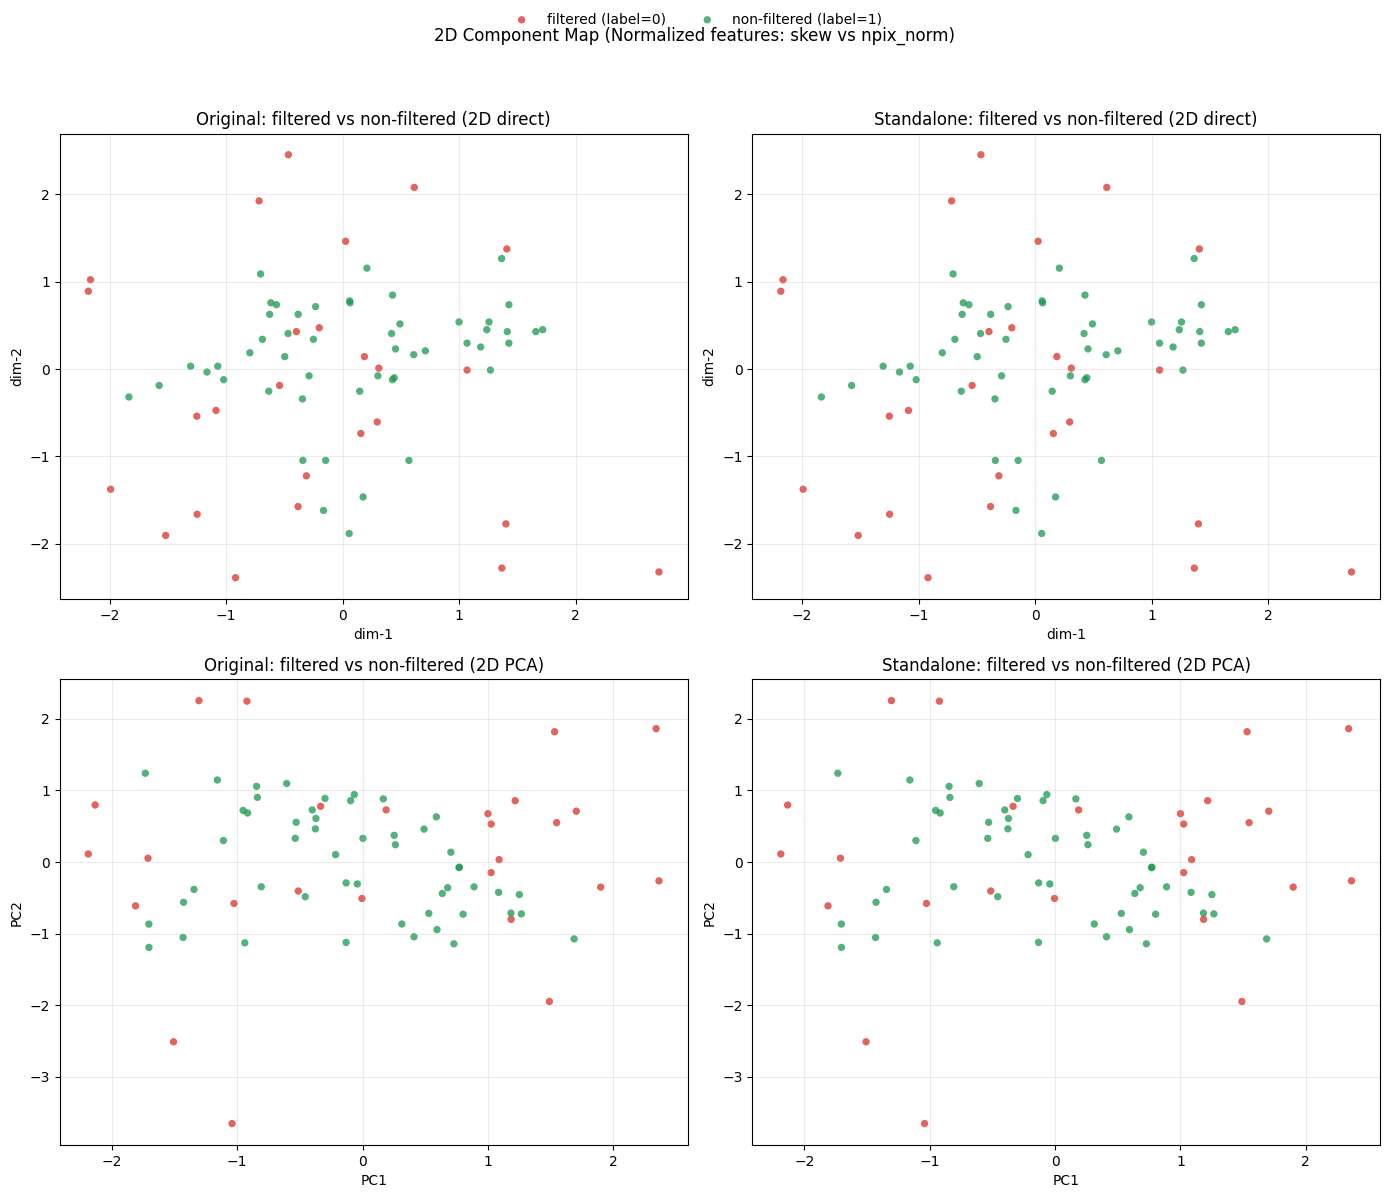

In [12]:
# 2D component visualization for filtered vs non-filtered ROIs.
stat_list = kwargs["stat"]

feature_keys = list(kwargs.get("keys") or [])
available_feature_keys = [k for k in feature_keys if k in stat_list[0]]

if not available_feature_keys:
    # Fallback to scalar numeric keys if capture keys are missing.
    numeric_keys = []
    for key, value in stat_list[0].items():
        if np.isscalar(value) and isinstance(value, (int, float, np.number)) and not isinstance(value, bool):
            numeric_keys.append(key)
    available_feature_keys = numeric_keys[:3]

if not available_feature_keys:
    raise RuntimeError("Could not find numeric ROI features for 2D visualization")

feature_matrix = np.array(
    [[float(roi[k]) for k in available_feature_keys] for roi in stat_list],
    dtype=np.float64,
)

if feature_matrix.ndim == 1:
    feature_matrix = feature_matrix[:, np.newaxis]

# Normalize features for stable geometry.
mu = np.nanmean(feature_matrix, axis=0, keepdims=True)
sigma = np.nanstd(feature_matrix, axis=0, keepdims=True)
sigma[sigma == 0] = 1.0
X = np.nan_to_num((feature_matrix - mu) / sigma, nan=0.0, posinf=0.0, neginf=0.0)

if X.shape[1] >= 2:
    direct_2d = X[:, :2]
    direct_axes_label = f"Normalized features: {available_feature_keys[0]} vs {available_feature_keys[1]}"
else:
    direct_2d = np.column_stack([X[:, 0], np.zeros(X.shape[0], dtype=np.float64)])
    direct_axes_label = f"Single normalized feature: {available_feature_keys[0]}"

if X.shape[1] >= 2:
    _, _, vh = np.linalg.svd(X, full_matrices=False)
    pca_2d = X @ vh[:2].T
else:
    pca_2d = direct_2d.copy()

expected_label = expected_output[:, 0].astype(bool)
standalone_label = new_output[:, 0].astype(bool)
label_mismatch = expected_label != standalone_label

print("2D visualization feature keys:", available_feature_keys)
print("n_components:", len(stat_list))
print("expected non-filtered (label=1):", int(expected_label.sum()))
print("expected filtered (label=0):", int((~expected_label).sum()))
print("standalone non-filtered (label=1):", int(standalone_label.sum()))
print("standalone filtered (label=0):", int((~standalone_label).sum()))
print("label mismatch count:", int(label_mismatch.sum()))


def draw_filtered_scatter(ax, points, labels, title):
    filtered = ~labels
    nonfiltered = labels

    if filtered.any():
        ax.scatter(
            points[filtered, 0],
            points[filtered, 1],
            s=28,
            c="#D73027",
            alpha=0.75,
            label="filtered (label=0)",
            edgecolors="none",
        )
    if nonfiltered.any():
        ax.scatter(
            points[nonfiltered, 0],
            points[nonfiltered, 1],
            s=28,
            c="#1A9850",
            alpha=0.75,
            label="non-filtered (label=1)",
            edgecolors="none",
        )
    if label_mismatch.any():
        ax.scatter(
            points[label_mismatch, 0],
            points[label_mismatch, 1],
            s=90,
            facecolors="none",
            edgecolors="black",
            linewidths=1.0,
            label="label mismatch",
        )

    ax.set_title(title)
    ax.grid(alpha=0.25)


fig, axes = plt.subplots(2, 2, figsize=(14, 12))

draw_filtered_scatter(
    axes[0, 0],
    direct_2d,
    expected_label,
    "Original: filtered vs non-filtered (2D direct)",
)
axes[0, 0].set_xlabel("dim-1")
axes[0, 0].set_ylabel("dim-2")


draw_filtered_scatter(
    axes[0, 1],
    direct_2d,
    standalone_label,
    "Standalone: filtered vs non-filtered (2D direct)",
)
axes[0, 1].set_xlabel("dim-1")
axes[0, 1].set_ylabel("dim-2")


draw_filtered_scatter(
    axes[1, 0],
    pca_2d,
    expected_label,
    "Original: filtered vs non-filtered (2D PCA)",
)
axes[1, 0].set_xlabel("PC1")
axes[1, 0].set_ylabel("PC2")


draw_filtered_scatter(
    axes[1, 1],
    pca_2d,
    standalone_label,
    "Standalone: filtered vs non-filtered (2D PCA)",
)
axes[1, 1].set_xlabel("PC1")
axes[1, 1].set_ylabel("PC2")

# Use one shared legend from first axis that has handles.
handles, labels = axes[0, 0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc="upper center", ncol=3, frameon=False)

fig.suptitle(
    f"2D Component Map ({direct_axes_label})",
    y=0.98,
)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [13]:
float_error_values = [row["max_abs_error"] for row in comparison_rows if row["max_abs_error"] is not None]
global_max_float_error = max(float_error_values) if float_error_values else 0.0

print("Final Summary")
print("=============")
print(f"Architecture guard initialized: {architecture_guard_initialized}")
print(f"Architecture guard active during execution: {architecture_guard_status}")
print(f"Island-rule static scan passed: {island_rule_static_ok}")
print(f"Helper import strategy: {import_strategy_used}")
print(f"Package import strategy: {package_import_strategy}")
print(f"Standalone package name: {standalone_package_name}")
print(f"Overall strict comparison PASS: {overall_pass}")
print(f"Global max absolute float error: {global_max_float_error}")
print(f"Label mismatch count: {int((expected_output[:,0] != new_output[:,0]).sum())}")

assert architecture_guard_status, "Architecture guard was not active during standalone execution"
assert island_rule_static_ok, "Island-rule static check failed"
assert overall_pass, "Strict comparison failed"


Final Summary
Architecture guard initialized: True
Architecture guard active during execution: True
Island-rule static scan passed: True
Helper import strategy: repo_root_bootstrap
Package import strategy: standard
Standalone package name: separation.classification
Overall strict comparison PASS: True
Global max absolute float error: 0.0
Label mismatch count: 0
